In [1]:
from IPython.core.display import HTML
css_file = "./notebook_style.css"
HTML(open(css_file, 'r').read())

# 2. Testing Scientific Codes

- [When should I test?](#When-should-I-test?)
- [Effective testing](#Effective-testing)
    * [Unit tests](#Unit-tests)
    * [Integration tests](#Integration-tests)
    * [Convergence tests](#Convergence-tests)
    * [Regression tests](#Regression-tests)
    * [Test driven development](#Test-driven-development)
- [Common problems and how to solve them](#Common-problems-and-how-to-solve-them)
    * [Randomness](#My-code-has-some-randomness-and-so-its-output-changes-every-time-I-run-it---what-can-I-test-for?)
    * [Unknown solutions](#I-don%27t-know-what-the-correct-solution-should-be)
    * [Building on other people's code](#I-didn%27t-write-most-of-the-code---how-do-I-know-that-the-bit-I-wrote-works?)
    * [Numerical error](#I-know-there-is-some-numerical-error-in-my-code---how-can-I-test-my-code-is-correct-up-to-this-error?)
- [Further reading](#Further-reading)

In [2]:
import numpy
from numpy.random import rand
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 18})
from scipy.integrate import quad
import unittest

In the experimental Sciences, new theories are developed by applying the Scientific method. This involves carrying out tests that are accurate, reproducible and reliable. In order for a test to be such, the experimental setup will be tested in order to show that it is working as designed and so as to eliminate or quantify any systematic errors. A result will not be trusted unless the experiment itself has been carried out to a suitable standard. 

In computational Science, we should apply the same principles to our code. A result should only be trusted if the code that has produced it has undergone rigorous testing which demonstrates that it is working as intended and that any limitations of the code (e.g. numerical errors) are understood and quantified. 

Unfortunately, testing scientific codes can be quite challenging. By their very nature, they are often built in order to investigate systems where the behaviour is to some extent unknown. They can be very complex, often built over a number of years (or even decades!) with contributions from a vast number of people. However, even for the most complicated of codes there are a number of different types of tests that we can apply in order for us to build robust, reliable code whose results can be trusted. 



![Good code](https://imgs.xkcd.com/comics/good_code.png )
##### Writing good code is hard - [xkcd](https://xkcd.com/844/)

## When should I test?

### Always and often

The earlier you start testing the better, as it will be possible to catch bugs as they develop and before they become too entrenched in the code. Once written, you should then try and execute tests every time changes are made. Continuous integration (see below) is a useful tool to use to make sure that tests are run frequently - once the tests are written and the CI setup, they can then be forgetten about to a certain extent, safe in the knowledge that if any bugs are introduced in changes to the code, they should be caught.

**However**, it is important to review your tests regularly. In code that is being actively developed, tests must be amended and new tests written so as to make sure that new features are also tested. Regression tests are useful here to test that changes to the code improve its performance rather than making it worse. Code coverage is a useful tool to make sure that all code is being tested. It's all very well having a testing suite, but if only 20% of the code has been tested, you still cannot trust that the other 80% of the code is producing reliable results. 

## Effective testing

In order to have an effective set of tests, it's necessary to make sure that the entire parameter space is tested, not just one or two nice cases. Of particular importance are edge and corner cases. If the code needs to run over a set of parameters, then edge cases are those which are at the beginning and end of this range. A corner case is then where one or more edge cases are combined. Such cases tend to be where errors most often arise, as often special code is required to deal with boundary values.

In the code below, we demonstrate the importance of testing edge cases. The code takes a vector $\mathbf{v}$ and normalises it $\hat{\mathbf{v}} = \frac{\mathbf{v} }{ |\mathbf{v}|}$. We see that if the code is run for the vector $(0,0)$, a `RuntimeWarning` is raised as the function is attempting to divide by zero. 

In [3]:
def normalise(v):
    norm = numpy.sqrt(numpy.sum(v**2))
    
    return v / norm

In [4]:
normalise(numpy.array([0,0]))

/home/alice/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


array([ nan,  nan])

We therefore need to amend our function for the case where the norm of the vector is zero. A possible solution is the function below.

In [5]:
def improved_normalise(v):
    norm = numpy.sqrt(numpy.sum(v**2))
    
    if norm == 0.:
        return v
    
    return v / norm

In [6]:
improved_normalise(numpy.array([0,0]))

array([0, 0])

Our improved function now tests to see if the norm is zero - if so, it returns the original vector rather than attempting to divide by zero. 

It is also important to check that the code breaks as expected. If the code input is garbage but it still manages to run as normal, that is not good behaviour and suggests some data validation of input parameters is needed. For example, let's  try to run our improved normalisation function on a string:

In [7]:
improved_normalise("I am a string")

TypeError: unsupported operand type(s) for ** or pow(): 'str' and 'int'

Python correctly spots that it cannot perform the power operation on a string and raises a `TypeError` exception. However, it would probably be more useful to implement some kind of type checking of the function inputs before this (e.g. using `numpy.isnumeric`), and/or make sure that the code that calls this function is capable of catching such exceptions.

### Unit tests

For complicated codes made up of many functions, it is useful to write a serious of tests that check small parts of the code - *units* - at a time. This makes it easier to track down the exact location of bugs. These units may be individual functions or groups of shorter functions. Unit tests therefore encourage good coding practice, as they require code to be modular. 

In the example below, we have three (very simple) functions: `squared` which returns the square of its input, `add_2` which adds 2 to its input and `square_plus_2` which calls the two previous functions to return $x^2+2$. To test this code, we could therefore write unit tests for the first two functions to check they are working correctly. We've used the `unittest` module here as it allows us to test that functions correctly raise exceptions when given invalid data.

In [8]:
def squared(x):
    return x*x

def add_2(x):
    return x + 2

def square_plus_2(x):
    return add_2(squared(x))

In [9]:
class test_units(unittest.TestCase):
    
    def test_squared(self):
        self.assertTrue(squared(-5) == 25)
        self.assertTrue(squared(1e5) == 1e10)
        self.assertRaises(TypeError, squared, "A string")
        
    def test_add_2(self):
        self.assertTrue(add_2(-5) == -3)
        self.assertTrue(add_2(1e5) == 100002)
        self.assertRaises(TypeError, add_2, "A string")
    
test_units().test_squared()
test_units().test_add_2()

### Integration tests

Once you've written your unit tests and are pretty confident that individual parts of the code work on their own, you than need to verify that these different parts work together. To see why this is needed, imagine you were asked to build a car, despite only having a vague idea of how everything fits together. You've been given all the different parts (the engine, the wheels, the steering wheel...) - these have all previously undergone rigorous testing and you have been assured that they all work fine. You put them all together to the best of your ability, but unfortunately cannot get the car to work. Much as with your code, despite the individual parts working, this is no guarantee that they will work when put together.

In the above example, we can add an integration test by writing a test for `square_plus_2` - this calls the other two functions, so we'll test that it does this properly.

In [10]:
class test_integration(unittest.TestCase):
    
    def test_square_plus_2(self):
        self.assertTrue(square_plus_2(-5) == 27)
        self.assertTrue(square_plus_2(1e5) == 10000000002)
        self.assertRaises(TypeError, square_plus_2, "A string")
        
test_integration().test_square_plus_2()

As we'll see below, integration tests can be difficult to design. They can encompass a small section of the code, e.g. to check that one function correctly calls another, all the way up to the entire code. Because they can involve many different functions, they are often a lot more complex than unit tests. 

### Convergence tests

Often we want to calculate a solution on some kind of grid. The solution we find is a discretised approximation of the exact continuous solution. As the resolution of the grid increases, the solution should approach exact solution. Convergence tests are a way of checking this. The solution is calculated for grids of various resolutions. If the code is working correctly, the error of the solution should decrease with increasing resolution approximately at an order that depends on the accuracy of the algorithm (until the error becomes so small it then becomes dominated by floating point errors). 

In the example below, we will demonstrate this by using the trapezium rule to approximate the integral of $\sin (x)$ with various different step sizes, $h$. By comparing the calculated errors to a line of gradient $h^2$, it can be seen that the numerical approximation is converging as expected at $O(h^2)$.

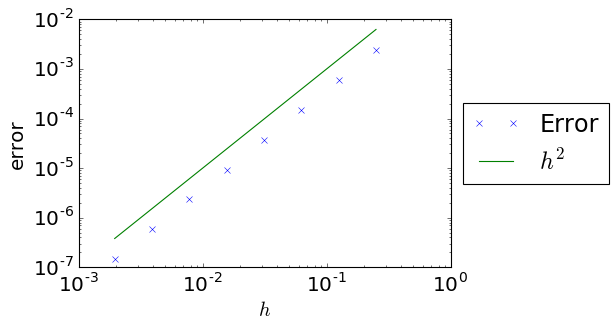

In [11]:
hs = numpy.array([1. / (4. * 2.**n) for n in range(8)])
errors = numpy.zeros_like(hs)

for i, h in enumerate(hs):
    xs = numpy.arange(0., 1.+h, h)
    ys = numpy.sin(xs)
    
    # use trapezium rule to approximate integral
    integral_approx = sum((xs[1:] - xs[:-1]) * 0.5 * (ys[1:] + ys[:-1]))
    errors[i] = -numpy.cos(1) + numpy.cos(0) - integral_approx
    
plt.loglog(hs, errors, 'x', label='Error')
plt.plot(hs, 0.1*hs**2, label=r'$h^2$')
plt.xlabel(r'$h$')
plt.ylabel('error')
plt.legend(loc='center left', bbox_to_anchor=[1.0, 0.5])
plt.show()

### Regression tests

When building your code, generally you'll be aiming for its performance to improve with time. Results should get more accurate or, at the very least, should not deteriorate. Regression tests are a way to check this. Multiple versions of the code are run and the outputs compared. If the output has changed such that it is significantly different from the previous output, the test fails. Such tests can help catch bugs that other types of tests may not, and can help ensure the project remains backwards-compatible for such cases where that is important. 

### Test driven development

Above we said that it's best to start testing your code early on in the development of your code. Test driven development this to the extreme: tests are written *before* you even write a line of the main code. The tests then take the form of a sort of 'product specification', providing a set of tests for things that you aim for your finished code to be able to do. In order to be able to write such tests, you need to have a good idea of the structure your code will have, so test driven development can be useful in that it forces you to plan out your code before you start writing it. 

Unfortunately, as we've seen, scientific codes can be difficult to test, often having unpredictable output. They often implement novel techniques, so it can be hard to plan what the final code will look like. This means that test driven development can be harder to successfully implement for scientific codes.

## Common problems and how to solve them

### My code has some randomness and so its output changes every time I run it - what can I test for?

In time evolution problems, it may be that whilst the output at any individual timestep can be somewhat random, the behaviour averaged over a number of timesteps is to some extent known. Tests can therefore be written to check that this is the case. In other problems, it may be more useful to test the average behaviour across the entire domain or sections of the domain. Even if the behaviour is completely random and so it's not possible to take any meaninful averages, the chances are that it should still be within a set of known values - we can therefore write tests that check the data is within these limits. Another strategy is to try to write tests that isolate the random parts so that you can check the non-random parts of the code work. If you are using a random number generator, it can be possible to eliminate the non-determinism by testing using a fixed seed value for the generator. 

In the code below, we generate an array of random data and apply some function to it before plotting the results. It can be seen that the output is different every time the code is run.

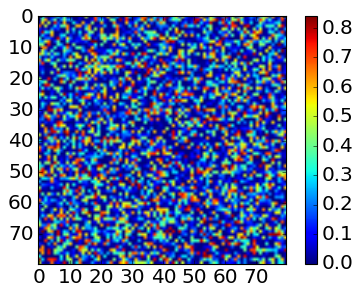

In [38]:
data = rand(80,80)

def func(a):
    return a**2 * numpy.sin(a)

output = func(data)

plt.imshow(output)
plt.colorbar()
plt.show()

The output of this code changes every time the code is run, however we can still write some tests for it. We know that all values in the output array must be $0\leq x \leq 1$. In some circumstances, such as in this case, we may know the statistical distribution of the random data. We can therefore calculate what the average output value should be and compare this to our code's output. In our case, the data is generated from a uniform distribution of numbers between 0 and 1, so the average value of the output is given by $\int_0^1 f(x) dx \simeq 0.22$

In [40]:
def test_limits(a):
    if numpy.all(a >= 0.) and numpy.all(a <= 1.):
        return True
    return False

def test_average(a):
    if numpy.isclose(numpy.average(a), 0.223, rtol=1.e-2):
        return True
    return False

if test_limits(output):
    print('Function output within correct limits')
else:
    print('Function output is not within correct limits')

if test_average(output):
    print('Function output has correct average')
else:
    print('Function output does not have correct average')

Function output within correct limits
Function output has correct average


### I don't know what the correct solution should be

In experimental science, the experimental setup will be tested using a control. This is where the experiment is run using a set of input data for which the outcome is known, so that any bugs in the apparatus or systematic errors can be identified. In computational science, there is often a simple system whose behaviour is known which can be used to test the code. E.g. in time evolution problems, a system which is initially static should remain that way. If this is not the case, then this indicates there is something seriously wrong with the code! In physics, we can also check for symmetries of the system (e.g. rotational symmetry, translation symmetry, reflection symmetry). There are also often conserved quantities (e.g. mass, energy, charge) that we can check the code conserves.

In the below example, we look at a black box function - `scipy.integrate.quad`. Here, this function will stand in for a bit of code that we have written and want to test. Say we wish to use `quad` to calculate the integral of some complicated function and we have little idea what the solution will be. Before we use it on the complicated function, we will test that it behaves correctly for a function whose integral we already know: $f(x) = \sin(x)$.

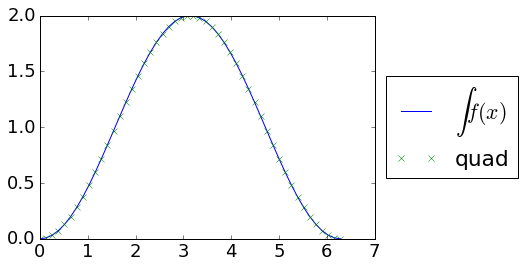

In [42]:
xs = numpy.linspace(0.0, 2.0 * numpy.pi)

integrals = numpy.zeros_like(xs) 

for i in range(len(xs)):
    integrals[i] = quad(numpy.sin, 0.0, xs[i])[0]

plt.plot(xs, -numpy.cos(xs)+1, '-', label=r'$\int f(x)$')
plt.plot(xs, integrals, 'x', label='quad')
plt.legend(loc='center left', bbox_to_anchor=[1.0, 0.5])
plt.show()

As hoped, quad gives the correct solution: 

$$
\int^\alpha_0 \sin(x)\, dx = -\cos(\alpha) + 1
$$

### I didn't write most of the code - how do I know that the bit I wrote works?

Unit tests! If the original code can run in isolation, make sure that there are suitable tests which make sure that it works correctly. Any failures in subsequent tests that then incorporate your code will therefore only be the result of bugs in your code. Unit tests of individual functions in your code should also be used. 

### I know there is some numerical error in my code - how can I test my code is correct up to this error?

In numerical calculations, there will always be some computational error that cannot be avoided. This can from the computer's floating point representation of numerical data or from the choice of algorithm used. It is often the case that we don't require our result to be 100% precise, but rather correct up to some tolerance. We can therefore build tests to reflect this. 

In python, we can use `numpy.isclose` and `numpy.allclose` to do this. In the example below, we take some data and add a small amount of random noise to it. This random noise is supposed to represent numerical errors that are introduced over the course of a simulation. If we test that the output array is equal to the original array, python correctly tells us that it is not. However, if we test that the output array is close to the original array, we find that this is true.

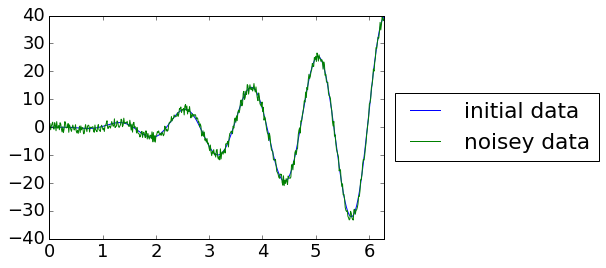

Noisey data is not exactly equal to initial data
Noisey data is close to initial data


In [43]:
x = numpy.linspace(0, 2*numpy.pi, num=500)
initial_data = x**2 * numpy.cos(5*x)

# add noise 
noisey_data = initial_data + (rand(len(x)) - 0.5) * 4

plt.plot(x, initial_data, label='initial data')
plt.plot(x, noisey_data, label='noisey data')
plt.legend(loc='center left', bbox_to_anchor=[1.0, 0.5])
plt.xlim(x[0], x[-1])
plt.show()

if numpy.array_equal(initial_data, noisey_data):
    print('Noisey data exactly equal to initial data')
else:
    print('Noisey data is not exactly equal to initial data')
    
if numpy.allclose(initial_data, noisey_data, atol=2):
    print('Noisey data is close to initial data')
else:
    print('Noisey data is not close to initial data')

Another tactic that can be used here is to employ convergence tests to make sure that the numerical error is decreasing with increasing resolution (at least until the point where this error becomes dominated by floating point erorrs). If you know that the algorithm you are using to solve the system is accurate to some order, your solution should converge at a rate close to this. If not, it is likely that you have made a mistake in your implementation of the algorithm.

## Further reading

![Continuous integration](images/continuous_integration.jpg)
##### Continuous integration - [Geek and poke](http://geekandpoke.typepad.com/geekandpoke/2010/10/geekpokes-list-of-best-practices-today-continuous-integration.html)